# Execise 3

## Goal
Retrieve the right parameters of the signal injected using template banks.

## Tasks
1. Inject multiple signals with different parameters and arrive to a mismatch graph (that is plot the probability of mismatch in a histogram) to evaluate template bank properties. You can introduce template banks files into prober (for more information use thw `−− help` command).
2. Inject a random signal setting -r to 1 with generate source. Arrive to a ROC curve analysing multiple signals.
3. Repeat with coarser and finer template banks. Obtain the parameters of the injected signal and compare the results using different tests and different template banks.

### Task 1
__Recall__

$M_i = 1 − S_i(∆⃗l)/ S_i(0),   i=1,2,3$

Where ∆⃗l is the distance vector between the point in the parameter space an the nearest template, and S(0) is the value of S on the right parameters of the signal.


#### Solution 

* Import functions from Exercise 1 to call _prober_ and _generate_source_ from python.


In [1]:
# Import some modules
import math as m
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import subprocess
import sys
import uuid

In [2]:
# Create a function to call generate_source with parameters
# First define a variable for the base command and executable path in my
base_cmd = "docker exec -i datalab" # can be empty for local use
exe_dir = "/home/code/" # directory where the executable is found
output_dir = "/home/code/data" # directory to save the data file
data_dir = "../../Codes/data" # directory for jupyter to find the data in

In [3]:
# Call generate source with given parameters
# Have some default values
def generate_source(
    outputFile=None, 
    sigma=0.25, 
    delta_T=None, 
    N=100000,
    f=0, 
    phi=0, 
    A=0, 
    r=0
):
    """
    Usage: ./generate_source  [-h] [-o <file>] [-s <float>] [-d <float>] [-N <int>] [-f <float>] [-p <float>] [-a <float>] [-r <int>]
      -o, --output=<file>       output file
      -s, --sigma=<float>       standard deviation sigma
      -d, --deltaT=<float>      delta T betwean measurements
      -N, --length=<int>        number of elements
      -f, --freq=<float>        frequency
      -p, --phase=<float>       phase
      -a, --amplitude=<float>   signal amplitude
      -r, --random=<int>        if set to 1, generate random signal
      -h, --help                print this help and exit
    """
    if delta_T == None : 
        delta_T = 1/N
    if outputFile == None:
        outputFile = "data_" + str(uuid.uuid4()) + ".csv"
    
    outputPath = os.path.join(output_dir, outputFile) # output_dir + "/" + "myfilename.csv"
    exe_path = os.path.join(exe_dir, 'generate_source')
    cmd_str = f"{base_cmd} {exe_path} -o {outputPath} -s {sigma} "\
        f"-d {delta_T} -N {N} -f {f} -p {phi} -a {A} -r {r}"
    
    # Optionally print the command line and test it outside the notebook
    #print(cmd_str)
    
    cmd = cmd_str.split(' ')
    process = subprocess.Popen(cmd,stdout=subprocess.PIPE)

    out, err = process.communicate()
    if err:
        print('The process raised an error:', err.decode())
    if out:
        print('The process has an output:', out.decode())

    return os.path.join(data_dir, outputFile)

In [4]:
def prober(inputFile, f=0, outputFile=None, phi=0, templateFile=None, mod=1):
    """
    Usage: ./prober  [-h] [-i <file>] [-o <file>] [-f <float>] [-p <float>] [-t <file>] [-m <int>]
      -i, --input=<file>        input file
      -o, --output=<file>       output file
      -f, --freq=<float>        frequency
      -p, --phase=<float>       phase
      -h, --help                print this help and exit
      -t, --templatebank=<file> template bank file
      -m, --method=<int>        select method to analyze signal 1, 2 or 3
    """
    
    inputFile = os.path.basename(inputFile)
    
    if outputFile == None:
        outputFile = "results_" + str(uuid.uuid4()) + ".csv"
    
    exe_path = os.path.join(exe_dir, 'prober')
    
    """
    prober -i data/data_01.csv -o data/results_01.csv -t template.txt -m 1
    """
    cmd_str = f"{base_cmd} {exe_path} -i {output_dir}/{inputFile} "\
        f"-o {output_dir}/{outputFile} -m {mod}"
    
    if templateFile:
        cmd_str += f" -t {output_dir}/{templateFile} "
    else:
        cmd_str += f" -f {f} -p {phi}"
    
    # Optionally print the command line and test it outside the notebook
    # print(cmd_str)
    
    cmd = cmd_str.split(' ')
    process = subprocess.Popen(cmd,stdout=subprocess.PIPE)
    out, err = process.communicate()
    if err:
        print('The process raised an error:', err.decode())
    if out:
        #print('The process has an output:', out.decode())
        return out.decode().split(' ')
    if os.path.isfile(outputFile):
        print(f"Output generated in file {outputFile}")

    return os.path.join(data_dir, outputFile)
    

__Next steps__:
1. Inject multiple signals
2. Plot the mismatch 
3. Change the template bank
    
    
__1. Inject multiple signals__

In [5]:
source_files = []
signal_freq = np.linspace(0.5, 100.5, 101)
sigma = 0.25
amplitude = 1
for freq in signal_freq:
    source_files.append(generate_source(f=freq, A=amplitude, sigma=sigma))

__2. Plot the mismatch__
For this first I will copy the latest function in Exercise 1 that gives me $S_i(best match)$ by using prober on a signal. 
I will modify this function such that givent the real frequency it returns the mismatch by using the formula $M_i = 1 - S_i(best match)/S_i(true value)$
When the function returns the mismatch we just have to plot it agains our frequency space.

In [6]:
def search_f_ph(datafile, freq=None, phase=None, N_df=100, f_min=0.01, f_max=20, mod=1, N_ph=50, title=None):
    # Make a frequency space from 0.01 to f_max with N_df steps
    freqs = np.linspace(f_min, f_max, N_df) 
    phases = np.linspace(0, 2*m.pi, N_ph)

    tbank = "tb_test_fphi.tb" # can parametrise this later
    
    # Generate template bank with this frequency space
    # You can also add phase space if feeling like doing a 3D plot
    with open(os.path.join(data_dir,tbank) ,'w') as tbfile:
        for f in freqs:
            for ph in phases:
                tbfile.write("{0} {1}\n".format(f,ph))

    results_file = prober(datafile, templateFile=tbank, mod=mod)
    results = np.loadtxt(results_file)
    
    # Plotting
    plt.figure(figsize=(15,4))
    if mod == 3:
        ### This is justa Fourier transform, template bank ignored 1/N frequencies tested
        best = np.where(results[:,2] == np.max(results[:,2]))
        plt.plot(results[:,0], results[:,2])
        plt.xscale('log')
        plt.xlabel("f [Hz]")
        plt.show()
        plt.close()
        
        #print(results[:,0][best][0], 0, results[:,2][best][0])
        
        return (results[:,0][best][0], 0, results[:,2][best][0])
    
    levels = np.linspace(np.min(results[:,2]),np.max(results[:,2]),30)
    CS = plt.contourf(results[:,0].reshape(N_df,N_ph),results[:,1].reshape(N_df,N_ph),results[:,2].reshape(N_df,N_ph),levels)
    
    if (freq and phase):
        plt.scatter(freq,phase,marker="x", label="Injection point")
    
    # Plot best match
    if mod == 1 :
        # For S_1 get the maximum
        plt.scatter(results[np.argmax(results[:,2])][0], results[np.argmax(results[:,2])][1], marker="o", label="Loudest point")
        best_phi, best_f, best_val = results[np.argmax(results[:,2])]
    elif mod == 2: 
        # For S_2 get the minimum
        plt.scatter(results[np.argmin(results[:,2])][0], results[np.argmin(results[:,2])][1], marker="o", label="Loudest point")
        best_phi, best_f, best_val = results[np.argmin(results[:,2])]
        
    plt.title(f"Searching over frequency and phase - 2D search $S_{mod}$")
    plt.legend(loc='best')
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Phase")
    plt.colorbar(CS, label="Prober output")
    plt.show()
    plt.close()
    
    ### Caluclate amplitude (look at data at peak)
    print(best_phi, best_f, best_val)
    
    return (best_phi, best_f, best_val)

In [7]:
def get_mismatch(
    datafile, 
    freq=None, 
    N_df=300, 
    f_min=0.5, 
    f_max=100.5, 
    mod=1
):
    # Make a frequency space from 0.01 to f_max with N_df steps
    # This time try to minimise the number of templates in the bank
    # such that you still get good detection
    freqs = np.linspace(f_min, f_max, N_df) 
    tbank = "tb_mismatch.tb" 
    
    # Generate template bank with this frequency space
    with open(os.path.join(data_dir,tbank) ,'w') as tbfile:
        for f in freqs:
            tbfile.write("{0} {1}\n".format(f,0))

    results_file = prober(datafile, templateFile=tbank, mod=mod)
    results = np.loadtxt(results_file)
    
    if mod == 3:
        best = np.where(results[:,2] == np.max(results[:,2]))
        resultsf_tv = prober(datafile, f=freq, mod=3)
        results_tv = np.loadtxt(resultsf_tv)
        S_best = results[:,2][best][0]
        S_tv = np.max(results_tv)
        M_i = 1 - (S_best/S_tv)
        
        return M_i
    
    # Plot best match
    if mod == 1 :
        # For S_1 get the maximum
        best_phi, best_f, best_val = results[np.argmax(results[:,2])]
        tv_phi, tv_f, tv_val = prober(datafile, f=freq, mod=1)
        M_i = 1 - float(best_val)/float(tv_val)
    elif mod == 2: 
        best_phi, best_f, best_val = results[np.argmin(results[:,2])]
        tv_phi, tv_f, tv_val = prober(datafile, f=freq, mod=2)
        M_i = 1 - abs(float(tv_val)-float(best_val)/float(tv_val))
        

    return M_i

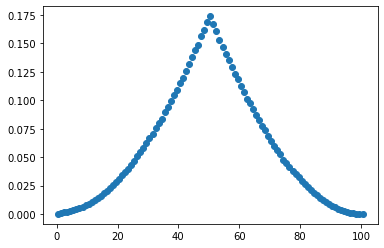

In [8]:
mismatches = []
for key, datafile in enumerate(source_files):
    file = datafile.replace(data_dir, '')
    mismatches.append(get_mismatch(file, freq=signal_freq[key], mod=1, N_df=300))

plt.scatter(signal_freq, mismatches)
plt.show()

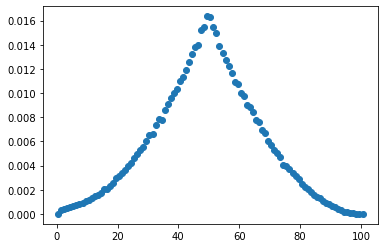

In [9]:
mismatches = []
for key, datafile in enumerate(source_files):
    file = datafile.replace(data_dir, '')
    mismatches.append(get_mismatch(file, freq=signal_freq[key], mod=1, N_df=1000))
    
plt.scatter(signal_freq, mismatches)
plt.show()

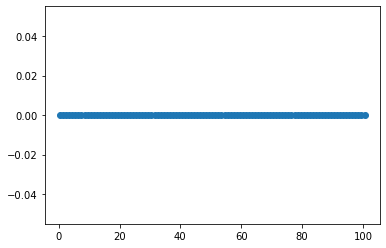

In [10]:
mismatches = []
for key, datafile in enumerate(source_files):
    file = datafile.replace(data_dir, '')
    mismatches.append(get_mismatch(file, freq=signal_freq[key], mod=1, N_df=1001))

plt.scatter(signal_freq, mismatches)
plt.show()

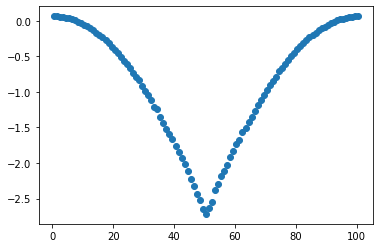

In [11]:
mismatches = []
for key, datafile in enumerate(source_files):
    file = datafile.replace(data_dir, '')
    mismatches.append(get_mismatch(file, freq=signal_freq[key], mod=2))

plt.scatter(signal_freq, mismatches)
plt.show()

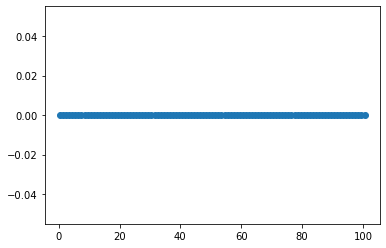

In [12]:
mismatches = []
for key, datafile in enumerate(source_files):
    file = datafile.replace(data_dir, '')
    mismatches.append(get_mismatch(file, freq=signal_freq[key], mod=3))

plt.scatter(signal_freq, mismatches)
plt.show()

Method 1


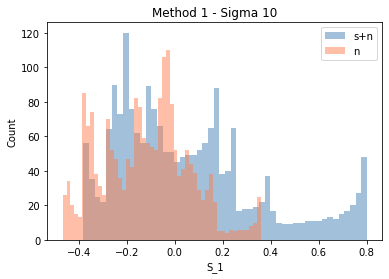

In [67]:
#number of trials for each s+n and pure noise:
sigma = 10
freq = 10
phase = 0
mod=1
n_dist = 2000
temp_bank = "histogram_test_tb.tb"
with open(os.path.join(data_dir, temp_bank),'w') as tbfile:
    for f in np.linspace(5, 15, 2000):
        tbfile.write("{0} {1}\n".format(f,phase))
print(f"Method {mod}")

prober_results_test = {'signal':np.zeros(n_dist), 'noise':np.zeros(n_dist)}
amp_dict = {'signal':1., 'noise':0.}

infile = generate_source(sigma=sigma, N=1000)
resultf = prober(infile, templateFile=temp_bank, mod=mod)
results = np.loadtxt(resultf)
prober_results_test['noise'] = results[:,2]

infile = generate_source(A=1, sigma=sigma,f=freq, N=1000)
resultf = prober(infile, templateFile=temp_bank, mod=mod)
results = np.loadtxt(resultf)
prober_results_test['signal'] = results[:,2]

plt.hist(prober_results_test['signal'], 50, facecolor='steelblue', alpha =0.5,label="s+n")
plt.hist(prober_results_test['noise'], 50, facecolor='coral', alpha=0.5, label="n")
plt.xlabel("S_{}".format(1))
plt.ylabel("Count")
plt.legend()
plt.title("Method 1 - Sigma %g" % sigma)
plt.show()
plt.close()

Method 1


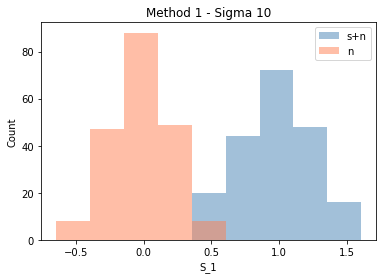

In [58]:
#number of trials for each s+n and pure noise:
n_dist = 200
sigma = 10
freq = 10
phase = 0
mod=1
tbank = "histogram_tb.tb"
with open(os.path.join(data_dir,tbank),'w') as tbfile:
    tbfile.write("{0} {1}\n".format(freq,phase))
print(f"Method {mod}")

prober_results_sigma10 = {'signal':np.zeros(n_dist), 'noise':np.zeros(n_dist)}
amp_dict = {'signal':1., 'noise':0.}

for i in range(n_dist):
    infile = generate_source(sigma=sigma, N=1000)
    resultf = prober(infile, templateFile=tbank, mod=mod)
    results = np.loadtxt(resultf)
    prober_results_sigma10['noise'][i] = results[2]

    infile = generate_source(A=2, sigma=sigma,f=freq, N=1000)
    resultf = prober(infile, templateFile=tbank, mod=mod)
    results = np.loadtxt(resultf)
    prober_results_sigma10['signal'][i] = results[2]

plt.hist(prober_results_sigma10['signal'], 5, facecolor='steelblue', alpha =0.5,label="s+n")
plt.hist(prober_results_sigma10['noise'], 5, facecolor='coral', alpha=0.5, label="n")
plt.xlabel("S_{}".format(1))
plt.ylabel("Count")
plt.legend()
plt.title("Method 1 - Sigma %g" % sigma)
plt.show()
plt.close()

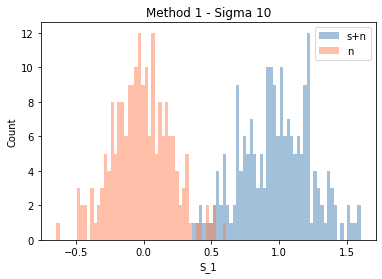

In [59]:
plt.hist(prober_results_sigma10['signal'], 50, facecolor='steelblue', alpha =0.5,label="s+n")
plt.hist(prober_results_sigma10['noise'], 50, facecolor='coral', alpha=0.5, label="n")
plt.xlabel("S_{}".format(1))
plt.ylabel("Count")
plt.legend()
plt.title("Method 1 - Sigma %g" % sigma)
plt.show()
plt.close()

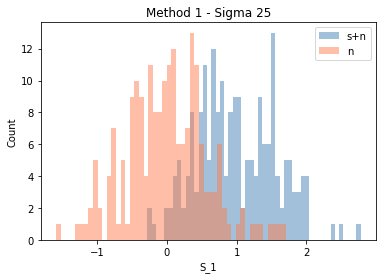

In [56]:
n_dist = 200
sigma=25
freq = 10

prober_results_sigma25 = {'signal':np.zeros(n_dist), 'noise':np.zeros(n_dist)}

for i in range(n_dist):
    infile = generate_source(sigma=sigma, N=1000)
    resultf = prober(infile, templateFile=tbank, mod=mod)
    results = np.loadtxt(resultf)
    prober_results_sigma25['noise'][i] = results[0,2]

    infile = generate_source(A=2, sigma=sigma,f=freq, N=1000)
    resultf = prober(infile, templateFile=tbank, mod=mod)
    results = np.loadtxt(resultf)
    prober_results_sigma25['signal'][i] = results[0,2]

plt.hist(prober_results_sigma25['signal'], 50, facecolor='steelblue', alpha =0.5,label="s+n")
plt.hist(prober_results_sigma25['noise'], 50, facecolor='coral', alpha=0.5, label="n")
plt.xlabel("S_{}".format(1))
plt.ylabel("Count")
plt.legend()
plt.title("Method 1 - Sigma %g" % sigma)
plt.show()
plt.close()

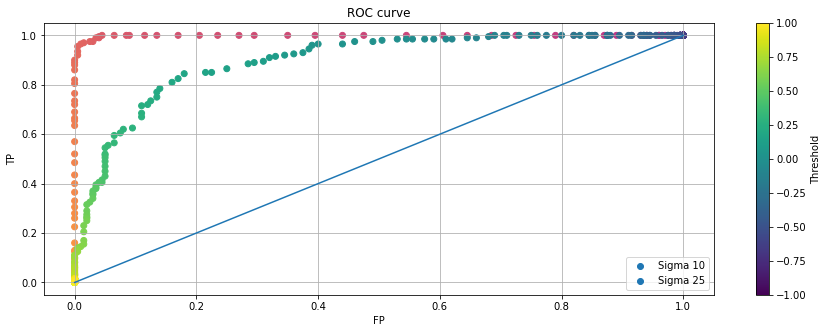

In [60]:
FPs_10 = [ 1.0 * len(np.where(prober_results_sigma10['noise'] >= thresh)[0]) / len(prober_results_sigma10['noise']) for thresh in np.linspace(-2.5, 2.5, 200)]    
TPs_10 = [ 1.0 * len(np.where(prober_results_sigma10['signal'] >= thresh)[0]) / len(prober_results_sigma10['signal']) for thresh in np.linspace(-2.5, 2.5, 200)]    
FPs_25 = [ 1.0 * len(np.where(prober_results_sigma25['noise'] >= thresh)[0]) / len(prober_results_sigma25['noise']) for thresh in np.linspace(-2.5, 2.5, 200)]    
TPs_25 = [ 1.0 * len(np.where(prober_results_sigma25['signal'] >= thresh)[0]) / len(prober_results_sigma25['signal']) for thresh in np.linspace(-2.5, 2.5, 200)]    

import matplotlib.cm as cm
fig = plt.figure(figsize= (15,5))
CB = plt.scatter(FPs_10, TPs_10, marker='o', c=np.linspace(-1.0, 1.0, 200), label='Sigma 10', cmap=cm.plasma)
CB = plt.scatter(FPs_25, TPs_25, marker='o', c=np.linspace(-1.0, 1.0, 200), label='Sigma 25', cmap=cm.viridis)

plt.legend(loc='lower right')
plt.plot([0,1])
plt.xlabel("FP")
plt.ylabel("TP")
plt.title("ROC curve")
plt.colorbar(CB, label="Threshold")
plt.grid()
plt.show()
plt.close()

Random signal 1
The process has an output: 702.378355
4.412986

The process has an output: 55.741347
0.349640

The process has an output: 420.397401
2.641071

The process has an output: 639.780546
4.019633

The process has an output: 496.939008
3.122044

The process has an output: 710.296636
4.462743

The process has an output: 571.677546
3.591687

The process has an output: 926.383824
5.820595

The process has an output: 643.787127
4.044810

The process has an output: 997.770890
6.269178

The process has an output: 214.703002
1.348525

The process has an output: 575.577088
3.616191

The process has an output: 435.162946
2.733854

The process has an output: 649.602945
4.081355

The process has an output: 12.082990
0.075299

The process has an output: 236.657801
1.486485

The process has an output: 84.590589
0.530923

The process has an output: 303.343797
1.905528

The process has an output: 660.021630
4.146825

The process has an output: 516.904389
3.247502

The process has an output: 

The process has an output: 283.231625
1.779146

The process has an output: 637.785718
4.007098

The process has an output: 996.290876
6.259878

The process has an output: 211.602634
1.329043

The process has an output: 570.039417
3.581393

The process has an output: 280.951797
1.764820

The process has an output: 647.056234
4.065352

The process has an output: 3.611470
0.022065

The process has an output: 219.969574
1.381619

The process has an output: 83.671227
0.525146

The process has an output: 437.556459
2.748895

The process has an output: 154.252504
0.968666

The process has an output: 9.420913
0.058571

The process has an output: 873.148611
5.486075

The process has an output: 232.834039
1.462457

The process has an output: 945.673475
5.941808

The process has an output: 308.160712
1.935796

The process has an output: 164.545330
1.033344

The process has an output: 878.001612
5.516570

The process has an output: 738.957644
4.642844

The process has an output: 957.019992
6.01310

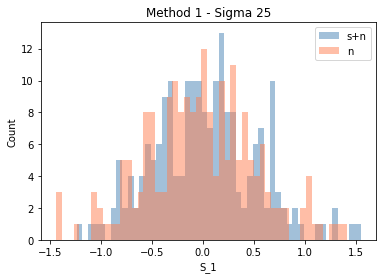

In [75]:
# Now with random signal
n_dist = 200
sigma=25
freq =10
tbank = "random_tb.tb"
with open(os.path.join(data_dir,tbank),'w') as tbfile:
    tbfile.write("{0} {1}\n".format(freq,phase))
print(f"Random signal {mod}")

prober_results_rand = {'signal':np.zeros(n_dist), 'noise':np.zeros(n_dist)}

for i in range(n_dist):
    infile = generate_source(sigma=sigma, N=1000)
    resultf = prober(infile, templateFile=tbank, mod=mod)
    results = np.loadtxt(resultf)
    prober_results_rand['noise'][i] = results[2]

    infile = generate_source(A=2, sigma=sigma,f=freq, N=1000, r=1)
    resultf = prober(infile, templateFile=tbank, mod=mod)
    results = np.loadtxt(resultf)
    prober_results_rand['signal'][i] = results[2]

plt.hist(prober_results_rand['signal'], 50, facecolor='steelblue', alpha =0.5,label="s+n")
plt.hist(prober_results_rand['noise'], 50, facecolor='coral', alpha=0.5, label="n")
plt.xlabel("S_{}".format(1))
plt.ylabel("Count")
plt.legend()
plt.title("Method 1 - Sigma %g" % sigma)
plt.show()
plt.close()

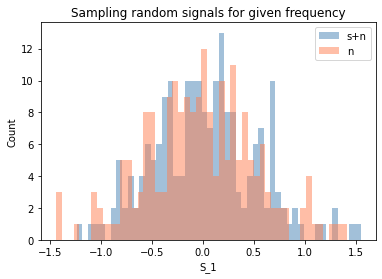

In [76]:
plt.hist(prober_results_rand['signal'], 50, facecolor='steelblue', alpha =0.5,label="s+n")
plt.hist(prober_results_rand['noise'], 50, facecolor='coral', alpha=0.5, label="n")
plt.xlabel("S_{}".format(1))
plt.ylabel("Count")
plt.legend()
plt.title("Sampling random signals for given frequency")
plt.show()
plt.close()

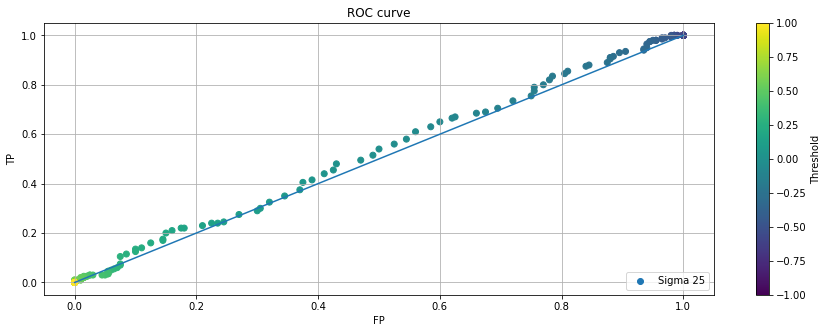

In [78]:
FP_rand = [ 1.0 * len(np.where(prober_results_rand['noise'] >= thresh)[0]) / len(prober_results_rand['noise']) for thresh in np.linspace(-2.5, 2.5, 200)]    
TP_rand = [ 1.0 * len(np.where(prober_results_rand['signal'] >= thresh)[0]) / len(prober_results_rand['signal']) for thresh in np.linspace(-2.5, 2.5, 200)]    


fig = plt.figure(figsize= (15,5))

CB = plt.scatter(FP_rand, TP_rand, marker='o', c=np.linspace(-1.0, 1.0, 200), label='Sigma 25', cmap=cm.viridis)

plt.legend(loc='lower right')
plt.plot([0,1])
plt.xlabel("FP")
plt.ylabel("TP")
plt.title("ROC curve")
plt.colorbar(CB, label="Threshold")
plt.grid()
plt.show()
plt.close()